In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sentiment-analysis-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F989445%2F1808590%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240625%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240625T040545Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D337cd76f3098816889fbb5f6428aaa21dbff4e2cc06907c8b942d41c0ee2c5d6bac0b684e4ffc425f3fdd89cf797864c6731c51d3da62938f597c52ef3d9f9f2f84265b49c58608c35df5e044427354426da40278f7894b0c2e7d2a4ba0a18e9740a64dd00e8b29947ebf131edc9891dee0d89aeb44e105415f20cf722b6824c4bb1a5206212cdb5e404152368f8bfa49d4afd3456572984cb0db30c09cc55aedfcc94e2ea9f8696b7416415f82b89e93ed85edc2428c9a8b05ae3c6e4f62ad31a4ae836056851ff3df323d8f73402d022aaa11ef9d03f4e38547d59c87cf3b09fbe2a8d8580de1dee7accb7b6e78eb20639e36dc2d760de7a23c978e12353ab'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 57092644 bytes downloaded
Downloaded and uncompressed: sentiment-analysis-dataset
Data source import complete.


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import Sequential
from keras.utils import to_categorical
from keras.layers import Dense,SimpleRNN,Embedding,Flatten

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
train_ds = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/train.csv',encoding='latin1');
validation_ds = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/test.csv',encoding='latin1');

In [ ]:
train_ds = train_ds[['text','sentiment']]
validation_ds = validation_ds[['text','sentiment']]

In [ ]:
train_ds['text'].fillna('',inplace=True)
validation_ds['text'].fillna('',inplace=True)

In [ ]:
def func(sentiment):
    if sentiment =='positive':
        return 0;
    elif sentiment =='negative':
        return 1;
    else:
        return 2;
train_ds['sentiment'] = train_ds['sentiment'].apply(func)
validation_ds['sentiment'] = validation_ds['sentiment'].apply(func)

In [ ]:
x_train = np.array(train_ds['text'].tolist())
y_train = np.array(train_ds['sentiment'].tolist())
x_test = np.array(validation_ds['text'].tolist())
y_test = np.array(validation_ds['sentiment'].tolist())

In [ ]:
x_train

array([' I`d have responded, if I were going',
       ' Sooo SAD I will miss you here in San Diego!!!',
       'my boss is bullying me...', ...,
       ' Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend  Take care hun xxxx',
       ' But it was worth it  ****.',
       '   All this flirting going on - The ATG smiles. Yay.  ((hugs))'],
      dtype='<U159')

In [ ]:
y_train

array([2, 1, 1, ..., 0, 0, 2])

In [ ]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [ ]:
y_train

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
tokenizer = Tokenizer(num_words=20000)

In [ ]:
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_test)

In [ ]:
len(tokenizer.word_index)

28614

In [ ]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
from keras.utils import pad_sequences
x_train = pad_sequences(x_train, padding='post', maxlen=35)  # Set maxlen to 35
x_test = pad_sequences(x_test, padding='post', maxlen=35)

In [ ]:
x_train[0]

array([   1,  162,   19, 7713,   71,    1,  151,   49,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [ ]:
x_train.shape

(27481, 35)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=5, input_length=35))
model.add(SimpleRNN(32,return_sequences=False))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 5)             100000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1216      
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 101315 (395.76 KB)
Trainable params: 101315 (395.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
859/859 [==============================] - 12s 12ms/step - loss: 0.9698 - accuracy: 0.5092 - val_loss: 0.8256 - val_accuracy: 0.7184
Epoch 2/10
859/859 [==============================] - 9s 10ms/step - loss: 0.7315 - accuracy: 0.6880 - val_loss: 0.6358 - val_accuracy: 0.7605
Epoch 3/10
859/859 [==============================] - 10s 12ms/step - loss: 0.5818 - accuracy: 0.7713 - val_loss: 0.6298 - val_accuracy: 0.7556
Epoch 4/10
859/859 [==============================] - 10s 12ms/step - loss: 0.4762 - accuracy: 0.8228 - val_loss: 0.6575 - val_accuracy: 0.7539
Epoch 5/10
859/859 [==============================] - 9s 11ms/step - loss: 0.3950 - accuracy: 0.8575 - val_loss: 0.6355 - val_accuracy: 0.7489
Epoch 6/10
859/859 [==============================] - 9s 10ms/step - loss: 0.3370 - accuracy: 0.8821 - val_loss: 0.7063 - val_accuracy: 0.7448
Epoch 7/10
859/859 [==============================] - 10s 12ms/step - loss: 0.2879 - accuracy: 0.9029 - val_loss: 0.8885 - val_accuracy: 0.

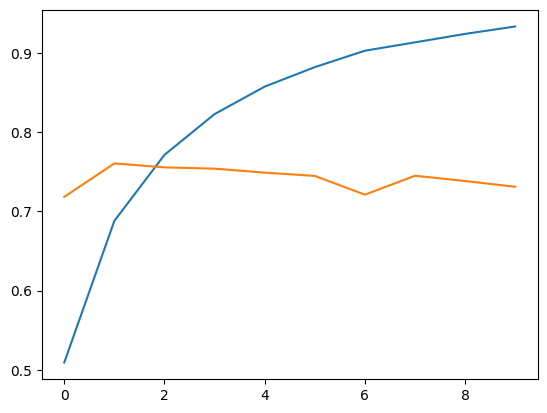

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:
# Prediction 1
text = "The movie was bad bad bad, i will not recommend this movie to anyone"

new_text_seq = tokenizer.texts_to_sequences([text])
new_text_padded = pad_sequences(new_text_seq, padding='post', maxlen=35)  # Use the max_len determined during training
predictions = model.predict(new_text_padded)
predicted_class_index = predictions.argmax(axis=-1)
if predicted_class_index[0] == 0:
    print("Postive Sentiment");
elif predicted_class_index[0] == 1:
    print("Negative Sentiment")
else:
    print("Neutral Sentiment")

1/1 [==============================] - 1s 553ms/step
Negative Sentiment


In [ ]:
# Prediction 2

text = "The movie was good, i will recommend this movie to anyone"

new_text_seq = tokenizer.texts_to_sequences([text])
new_text_padded = pad_sequences(new_text_seq, padding='post', maxlen=35)  # Use the max_len determined during training
predictions = model.predict(new_text_padded)
predicted_class_index = predictions.argmax(axis=-1)
if predicted_class_index[0] == 0:
    print("Postive Sentiment");
elif predicted_class_index[0] == 1:
    print("Negative Sentiment")
else:
    print("Neutral Sentiment")

1/1 [==============================] - 0s 22ms/step
Postive Sentiment
